In [1]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import Table

from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

## Cluster

In [2]:
grps = Table.read("./data/group_DR7/modelA_group", format = 'ascii')

grps['col1'].name = 'id'
grps['col2'].name = 'RA'
grps['col3'].name = 'dec'
grps['col4'].name = 'z'
grps['col5'].name = 'L'
grps['col6'].name = 'sm'
grps['col7'].name = 'hm1'
grps['col8'].name = 'hm2'
grps['col9'].name = 'mean_sep1'
grps['col10'].name = 'mean_sep2'
grps['col11'].name = 'f_edge'
grps['col12'].name = 'ID1'
grps['col13'].name = 'ID2'

mask_m = (grps['hm1'] > np.log10(2e12))
mask_z = (grps['z'] > 0.015) & (grps['z'] < 0.055)
mask_coord = ((grps['RA'] < 70) | (grps['RA'] > 290)) & ((grps['dec'] < 1.5) & (grps['dec'] > -1.5))
mask_grp = mask_m & mask_z & mask_coord

grps = grps[mask_grp]


In [3]:
ra_grp = grps['RA']
dec_grp = grps['dec']
zz_grp = grps['z']
dist_grp = cosmo.comoving_distance(zz_grp).value # Mpc

coords = SkyCoord(ra = ra_grp * u.degree, dec = dec_grp * u.degree, distance = dist_grp * u.Mpc)

x_grp = coords.cartesian.x
y_grp = coords.cartesian.y
z_grp = coords.cartesian.z

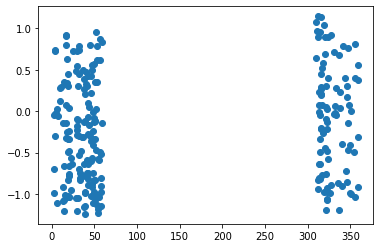

In [4]:
fig, ax = plt.subplots()

ax.scatter(ra_grp, dec_grp)

## Stripe82

In [36]:
cat = Table.read("./data/s82grfn.fit")

ra_gal = cat['RAJ2000'].value
dec_gal = cat['DEJ2000'].value
zz_gal = cat['z'].value

dist_gal = cosmo.comoving_distance(zz_gal).value # Mpc

coords_gal = SkyCoord(ra = ra_gal * u.degree, dec = dec_gal * u.degree, distance = dist_gal * u.Mpc)

x_gal = coords_gal.cartesian.x
y_gal = coords_gal.cartesian.y
z_gal = coords_gal.cartesian.z

In [6]:
#  1. group id; 
#  2. member galaxy id in NYU_VAGC
#  3. member galaxy id in SDSS7?
grps_mems = Table.read('./data/group_DR7/imodelA_2', format = 'ascii')

mask = np.isin(grps_mems['col1'], grps['id'])
grps_mems = grps_mems[mask]

In [12]:
len(grps_mems), len(grps)

(1275, 248)

In [5]:
# col  1: galaxy ID
# col  2: NYU-VAGC ID : object ID (row in NYU-VAGC files)
# col  3: ra 
# col  4: dec
# col  5: z redshift
# col  6: apparent magnitude r_band (SDSS magnitude)
# col  7: magnitude limit r_band
# col  8: completeness in this region
# col  9: ^{0.1}M_r-5\log h  (K+E corrected to z=0.1) -- Petro
# col 10: ^{0.1}(g-r)  color (K+E corrected to z=0.1) -- Petro
# col 11: ^{0.1}M_r-5\log h  (K+E corrected to z=0.1) -- Model
# col 12: ^{0.1}(g-r)  color (K+E corrected to z=0.1) -- Model
# col 13: redshift source type: 1 SDSS; 2 other; 3 KSG-VAGC; 4 nearest 
#         5 from X-ray clusters (last 30)
#         * for those with negtive values (469), photometries are update
#           according to their parents. 
dr7 = Table.read('./data/galaxy_DR7/SDSS7', format = 'ascii')

In [27]:
# grps_mems['col3']

In [30]:
mask = np.isin(dr7['col2'], grps_mems['col2'])
dr7_cands = dr7[mask]

In [31]:
len(dr7_cands)

1275

In [32]:
len(dr7_cands)

1275

In [37]:
dr7_cands.write('./data/galaxy_DR7/SDSS7_matched.cat', format = 'ascii')

In [38]:
dr7_cands[0]

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
2,751,38.352526239,0.212490935,0.0538176,16.786047,17.6200008,0.9878049,-19.3635311,0.8207065,-19.3689442,0.8517601,1


In [39]:
coords_dr7 = SkyCoord(ra = dr7_cands['col3'] * u.degree, dec = dr7_cands['col4'] * u.degree)

In [40]:
coords_s82 = SkyCoord(ra = ra_gal * u.degree, dec = dec_gal * u.degree)

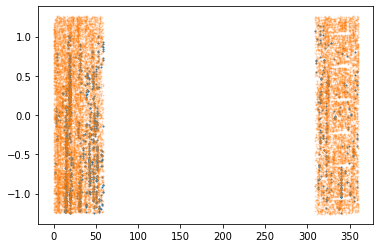

In [42]:
plt.scatter(dr7_cands['col3'], dr7_cands['col4'], s = 1)
plt.scatter( ra_gal, dec_gal, s = 1, alpha = .2)

In [43]:
max(dec_gal), min(dec_gal)

(1.25862, -1.25804)

In [44]:
dr7_cands['col4']

0.212490935
0.210653925
0.614347581
1.006723478
0.99313494
0.918866616
0.912559395
0.875482449
0.911073543
0.861910978
0.932008064


In [45]:
from astropy.coordinates import match_coordinates_sky


In [46]:
idx, d2d, d3d = match_coordinates_sky(coords_dr7, coords_s82)

In [51]:
max_sep = 1.0 * u.arcsec
sep_constraint = d2d < max_sep

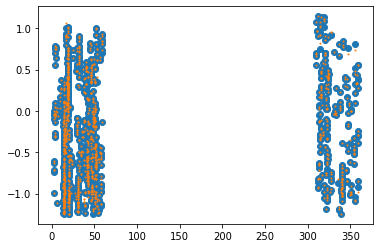

In [62]:
plt.scatter(coords_dr7.ra.value, coords_dr7.dec.value)
plt.scatter(coords_s82[idx].ra.value, coords_s82[idx].dec.value, s = 1)

# plt.scatter(coords_dr7[sep_constraint].ra.value, coords_s82[idx[sep_constraint]].ra.value, alpha = .2)

In [70]:
# dr7_cands[sep_constraint]['col2']
# cat[idx[sep_constraint]]['recno']

In [73]:
tbl = Table()

tbl['ds7_col2'] = dr7_cands[sep_constraint]['col2']
tbl['s82_recno'] = cat[idx[sep_constraint]]['recno']

tbl.write('./data/galaxy_DR7/SDSS7_S82_matched_id.cat', format = 'ascii')

## id files

In [9]:
#  1) IGAL   : a simple counter, from 1 to Ngal
#  2) VAGC ID: object ID (row in NYU-VAGC files)
#  3) MJD    : spectroscopic id
#  4) PLATE  : spectroscopic id
#  5) FIBERID: spectroscopic id
#  6) RUN    : photometric id
#  7) RERUN  : photometric id
#  8) CAMCOL : photometric id
#  9) FIELD  : photometric id
# 10) ID     : photometric id

# NOTE: These IDs are only needed if one wants to identify the object
#       in the original SDSS data files
grps_ids = Table.read('./data/galaxy_DR7/SDSS7_ID', format = 'ascii')

In [11]:
# from utils.sdss import objid_extract

In [12]:
mask = np.isin(grps_ids['col1'], grps_mems['col3'])
grps_ids = grps_ids[mask]

In [13]:
grps_ids

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
2,751,51820,407,594,109,137,4,88,92
3,752,51821,408,351,109,137,4,128,111
23,1128,51811,416,543,109,137,5,345,233
258,3195,51869,414,529,109,137,6,117,117
259,3196,51869,414,525,109,137,6,117,150
260,3201,51869,414,578,109,137,6,117,200
261,3202,52178,713,331,109,137,6,117,203
319,3645,52901,1242,335,109,137,6,148,133
347,3783,52901,1242,578,109,137,6,156,191


In [ ]:
# run
idx = 10
mask = (
        # (grps_ids['col6'][idx] == cat['run']) 
        # & (grps_ids['col7'][idx] == cat['rerun'])
        (grps_ids['col8'][idx] == cat['camcol'])
        & (grps_ids['col9'][idx] == cat['field'])
        # & (grps_ids['col10'][idx] == cat['fieldID'])
)
np.where(mask)[0]

array([6532, 7949, 8095, 8261, 8737, 9751])

In [ ]:
grps_ids[idx]

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10
int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
350,3803,52901,1242,615,109,137,6,158,115


In [ ]:
from numpy import int8


def objid_merge(sky, run, rerun, camcol, field, object_id):
    superid: int8 = 0
    superid = (superid | (sky << 59) | (rerun << 48) | (run << 32) | (camcol << 29) | (0 << 28) | (field << 16) | (object_id << 0))
    return superid

In [ ]:
objid_merge(15, 206, 2, 6, 158, 482)

8647475122499617250

In [ ]:
objid_extract(cat[mask][0]['S82ID']), objid_extract(cat[mask][0]['SDSSID'])

({'sky_version': 15,
  'rerun': 2,
  'run': 206,
  'camcol': 6,
  'first_field': 0,
  'field': 158,
  'object_id': 482},
 {'sky_version': 1,
  'rerun': 40,
  'run': 2662,
  'camcol': 6,
  'first_field': 0,
  'field': 39,
  'object_id': 199})

In [ ]:
cat[mask]

recno,S82ID,SDSSID,RAJ2000,DEJ2000,run,rerun,camcol,field,fieldID,rPmag,Ar,z,Nx,Ny,prcHost,prcStart,prcEnd,e_Fr,Fr,e_fr_lc,e_rmag,rmag,e_rmag_lc,e_B_Tr,B_Tr,e_b_tr_lc,e_radb,radb,e_radb_lc,e_be,be,e_be_lc,e_PAb,PAb,e_pab_lc,e_radd,radd,e_radd_lc,e_inc,inc,e_inc_lc,e_PAd,PAd,e_pad_lc,e_dxg,dxg,e_dxg_lc,e_dyg,dyg,e_dyg_lc,e_bkr,bkr,e_bkr_lc,e_n,n,e_n_lc,hlrr,chi2r,c1r,c2r,c3r,c4r,asymr,e_asymr,Az21r,Az22r,Az31r,Az32r,Az51r,Az52r,Dzr,RT11r,RT12r,RT13r,RA11r,RA12r,RA13r,prcflag,raddkpc,radbkpc,hlrrkpc,R50r,mu50r,Vmax,rMAGG,rMAGb,rMAGd,gMAGG,gMAGb,gMAGd,Ag,gPmag,e_Fg,Fg,e_fg_lc,e_B_Tg,B_Tg,e_b_tg_lc,e_gmag,gmag,e_gmag_lc,hlrg,hlrgkpc,chi2g,e_bkg,bkg,e_bkg_lc,c1g,c2g,c3g,c4g,R50g,mu50g,asymg,e_asymg,Az21g,Az22g,Az31g,Az32g,Az51g,Az52g,Dzg,RT11g,RT12g,RT13g,RA11g,RA12g,RA13g,SpClass,e_dxr,dxr,e_dxr_lc,e_dyr,dyr,e_dyr_lc,crhg,crhr,PpS,Pn4,Npxfit0,Npxfit1,e_skyr,e_skyg,skyr,skyg,skyNpixg,skyNpixr
,,,deg,deg,,,,,,mag,mag,,,,,'Y:M:D','Y:M:D',ct / s,ct / s,ct / s,mag,mag,mag,,,,arcsec,arcsec,arcsec,,,,deg,deg,deg,arcsec,arcsec,arcsec,deg,deg,deg,deg,deg,deg,pix,pix,pix,pix,pix,pix,ct / s,ct / s,ct / s,,,,arcsec,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,kpc,arcsec,mag / arcsec2,Mpc3,mag,mag,mag,mag,mag,mag,mag,mag,ct / s,ct / s,ct / s,,,,mag,mag,mag,arcsec,kpc,,ct / s,ct / s,ct / s,,,,,arcsec,mag / arcsec2,,,,,,,,,,,,,,,,,pix,pix,pix,pix,pix,pix,arcsec,arcsec,,,,,ct / (pix s),ct / (pix s),ct / (pix s),ct / (pix s),,
int32,int64,int64,float64,float64,int16,int16,int16,int16,int16,float64,float64,float64,int16,int16,bytes15,bytes10,bytes10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,int32
6533,8647475122499617250,587731187798573255,323.618,1.22123,206,2,6,158,482,15.15,0.162,0.064256,185,185,r01u36.llaima.u,2018-01-09,2018-01-09,3555.0,1087520.0,4891.0,0.005,14.909,0.004,0.005,0.406,0.044,0.0978434,3.41699,0.730458,0.016,0.507,0.007,0.428,101.178,0.314,0.183407,5.93161,0.034463,0.038,51.787,0.042,0.032,95.972,0.173,0.016,0.926,0.005,0.01,0.829,0.012,0,2.363,0,0.082,7.515,0.426,7.92254,3.4608,0.398,0.529,0.627,0.721,0.057,0.029,0.03,0.05,0.026,0.044,0.01,0.017,0.052,0.043,0.057,0.067,0.023,0.033,0.051,0,7.32708,4.22087,9.7864,4.77846,20.5419,0,-22.6442,-21.6655,-22.0786,-21.9757,-20.905,-21.4689,0.224,16.07,652.6,479464.0,713.7,0.006,0.373,0.048,0.002,15.798,0.001,8.1206,10.0311,2.6402,0,1.733,0,0.364,0.521,0.615,0.703,4.8932,21.5134,0.06,0.037,0.029,0.061,0.024,0.055,0.007,0.023,0.062,0.043,0.059,0.07,0.024,0.031,0.049,0,0.01,0.872,0.021,0.033,1.013,0.009,6.48856,6.31823,0.0,0.299403,19220,7444,0.045576,0.027408,1.85294,1.46125,20000,20000
7950,8647475122499617460,587731187798638924,323.65,1.12144,206,2,6,158,692,17.24,0.171,0.049916,79,79,r01u32.llaima.u,2018-01-09,2018-01-09,800.9,152040.0,268.4,0.002,17.045,0.006,0.021,0.83,0.009,0.0546655,1.45814,0.0126761,0.027,0.316,0.011,0.371,19.768,0.446,0.00594191,0.908319,0.00396127,0.079,63.395,0.117,0.256,20.396,0.435,0.01,0.723,0.006,0.009,0.816,0.007,0,0.028,0,0.011,5.815,0.017,1.48151,1.0415,0.658,0.799,0.864,0.905,0.082,0.029,-0.001,-0.001,0.0,0.0,0.0,0.0